In [14]:
%load_ext autoreload
%autoreload 2

from beqanalyser import DistanceParams
from beqanalyser.analyser import HDBSCANParams, build_all_composites
import numpy as np
from collections import defaultdict
from beqanalyser.loader import load, load_or_compute_distance_matrix

min_freq = 5
max_freq = 50
fan_counts = (5, 10, 20, 50, 100)
use_constraints = True

catalogue, data_hash = load()
by_author_by_year = defaultdict(lambda: defaultdict(int))

freqs = catalogue[0].mag_freqs
in_band_freqs = freqs[(freqs >= min_freq) & (freqs <= max_freq)]
responses_db = np.array([f.mag_db - f.mag_db[-1] for f in catalogue])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
distance_params = DistanceParams()

full_distance_matrix = load_or_compute_distance_matrix(
    input_curves=responses_db,
    freqs=freqs,
    band=(min_freq, max_freq),
    distance_params=distance_params,
    data_hash=data_hash,
)

In [16]:

params = [
    HDBSCANParams(
        min_cluster_size=50, min_samples=10, cluster_selection_epsilon=10.0
    ),
    HDBSCANParams(
        min_cluster_size=50, min_samples=10, cluster_selection_epsilon=10.0
    ),
    HDBSCANParams(
        min_cluster_size=50, min_samples=8, cluster_selection_epsilon=10.0
    ),
    HDBSCANParams(
        min_cluster_size=50, min_samples=5, cluster_selection_epsilon=10.0
    ),
    HDBSCANParams(
        min_cluster_size=20, min_samples=5, cluster_selection_epsilon=10.0
    ),
    HDBSCANParams(
        min_cluster_size=20, min_samples=5, cluster_selection_epsilon=10.0
    ),
]

result = build_all_composites(
    input_curves=responses_db,
    freqs=freqs,
    band=(min_freq, max_freq),
    fan_counts=fan_counts,
    iteration_params=params,
    distance_params=distance_params,
    full_distance_matrix=full_distance_matrix,
    final_assignment_threshold_multiplier=1.0
)

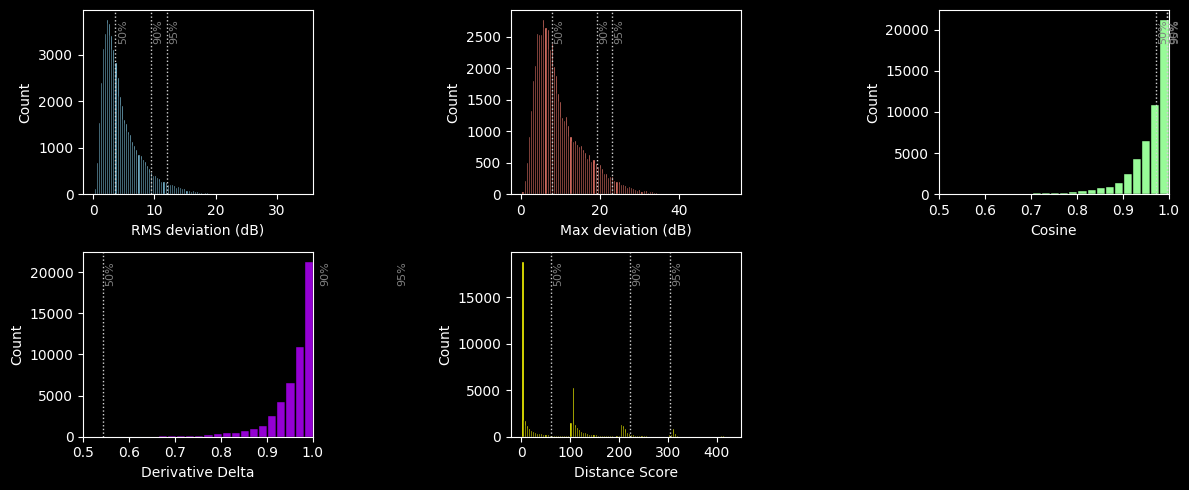

In [4]:
from beqanalyser.reporter import plot_distance_histograms

plot_distance_histograms(result.composites)

In [5]:
from beqanalyser.reporter import plot_distance_by_composite

plot_distance_by_composite(result.composites, in_band_freqs)

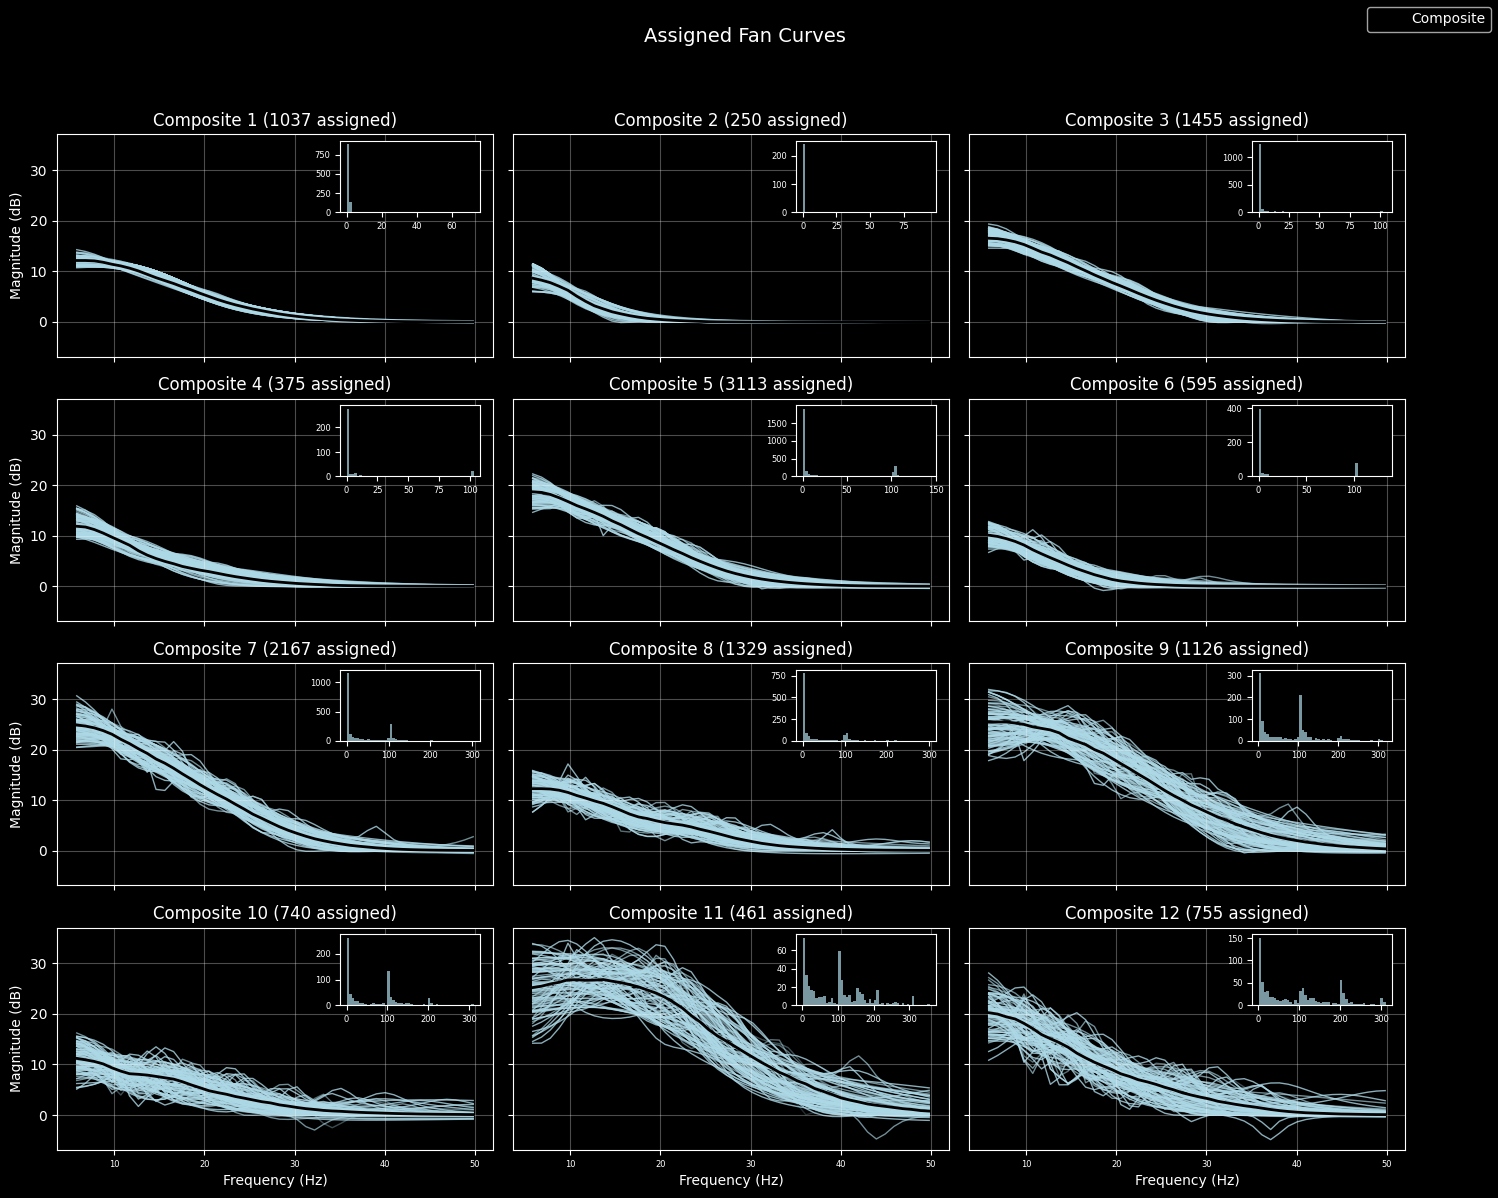

In [6]:
from beqanalyser.reporter import plot_assigned_fan_curves

plot_assigned_fan_curves(result.composites, in_band_freqs)

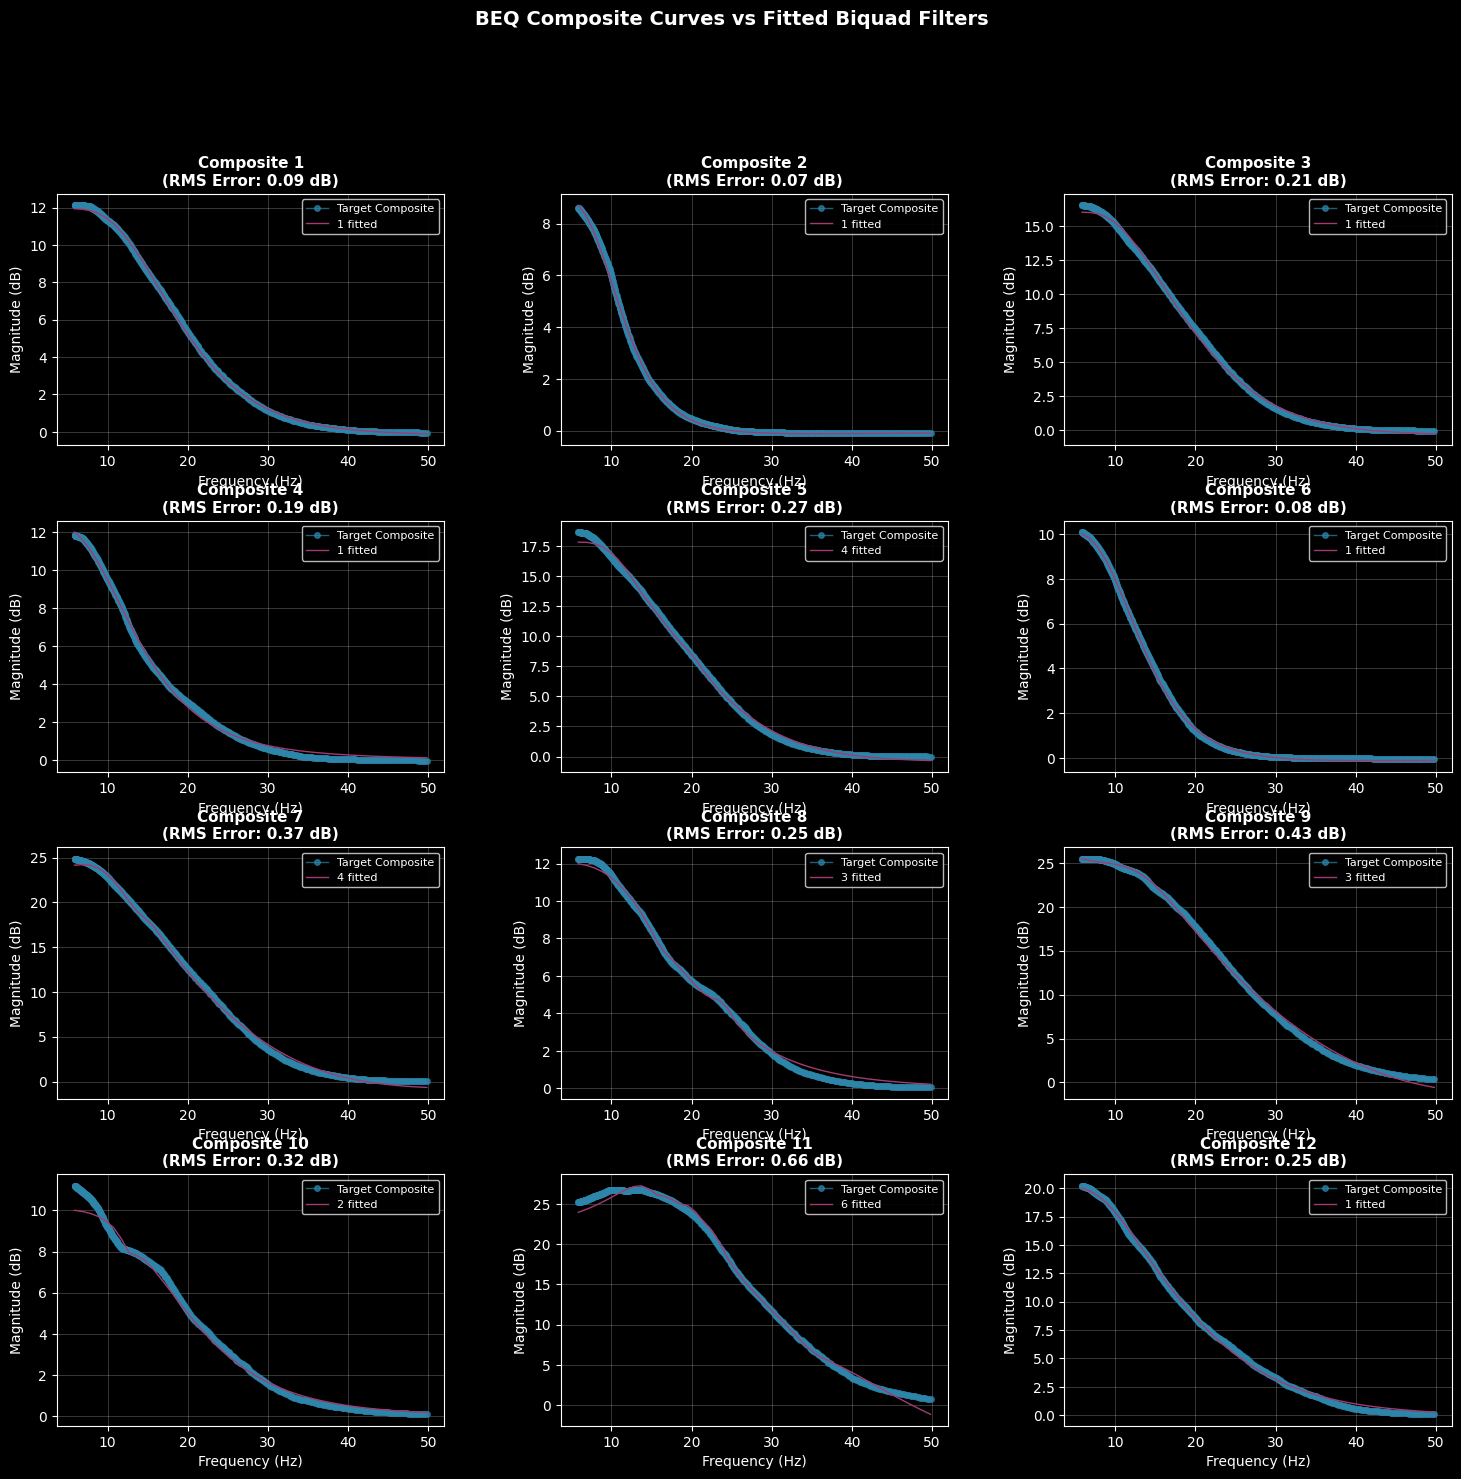

In [7]:
from beqanalyser.reporter import plot_filter_comparison
from beqanalyser.filter import fit_all_composites_to_peq

peq_fit = fit_all_composites_to_peq(result.composites, in_band_freqs, max_filters=6, residual_threshold=0.1)
plot_filter_comparison(peq_fit)

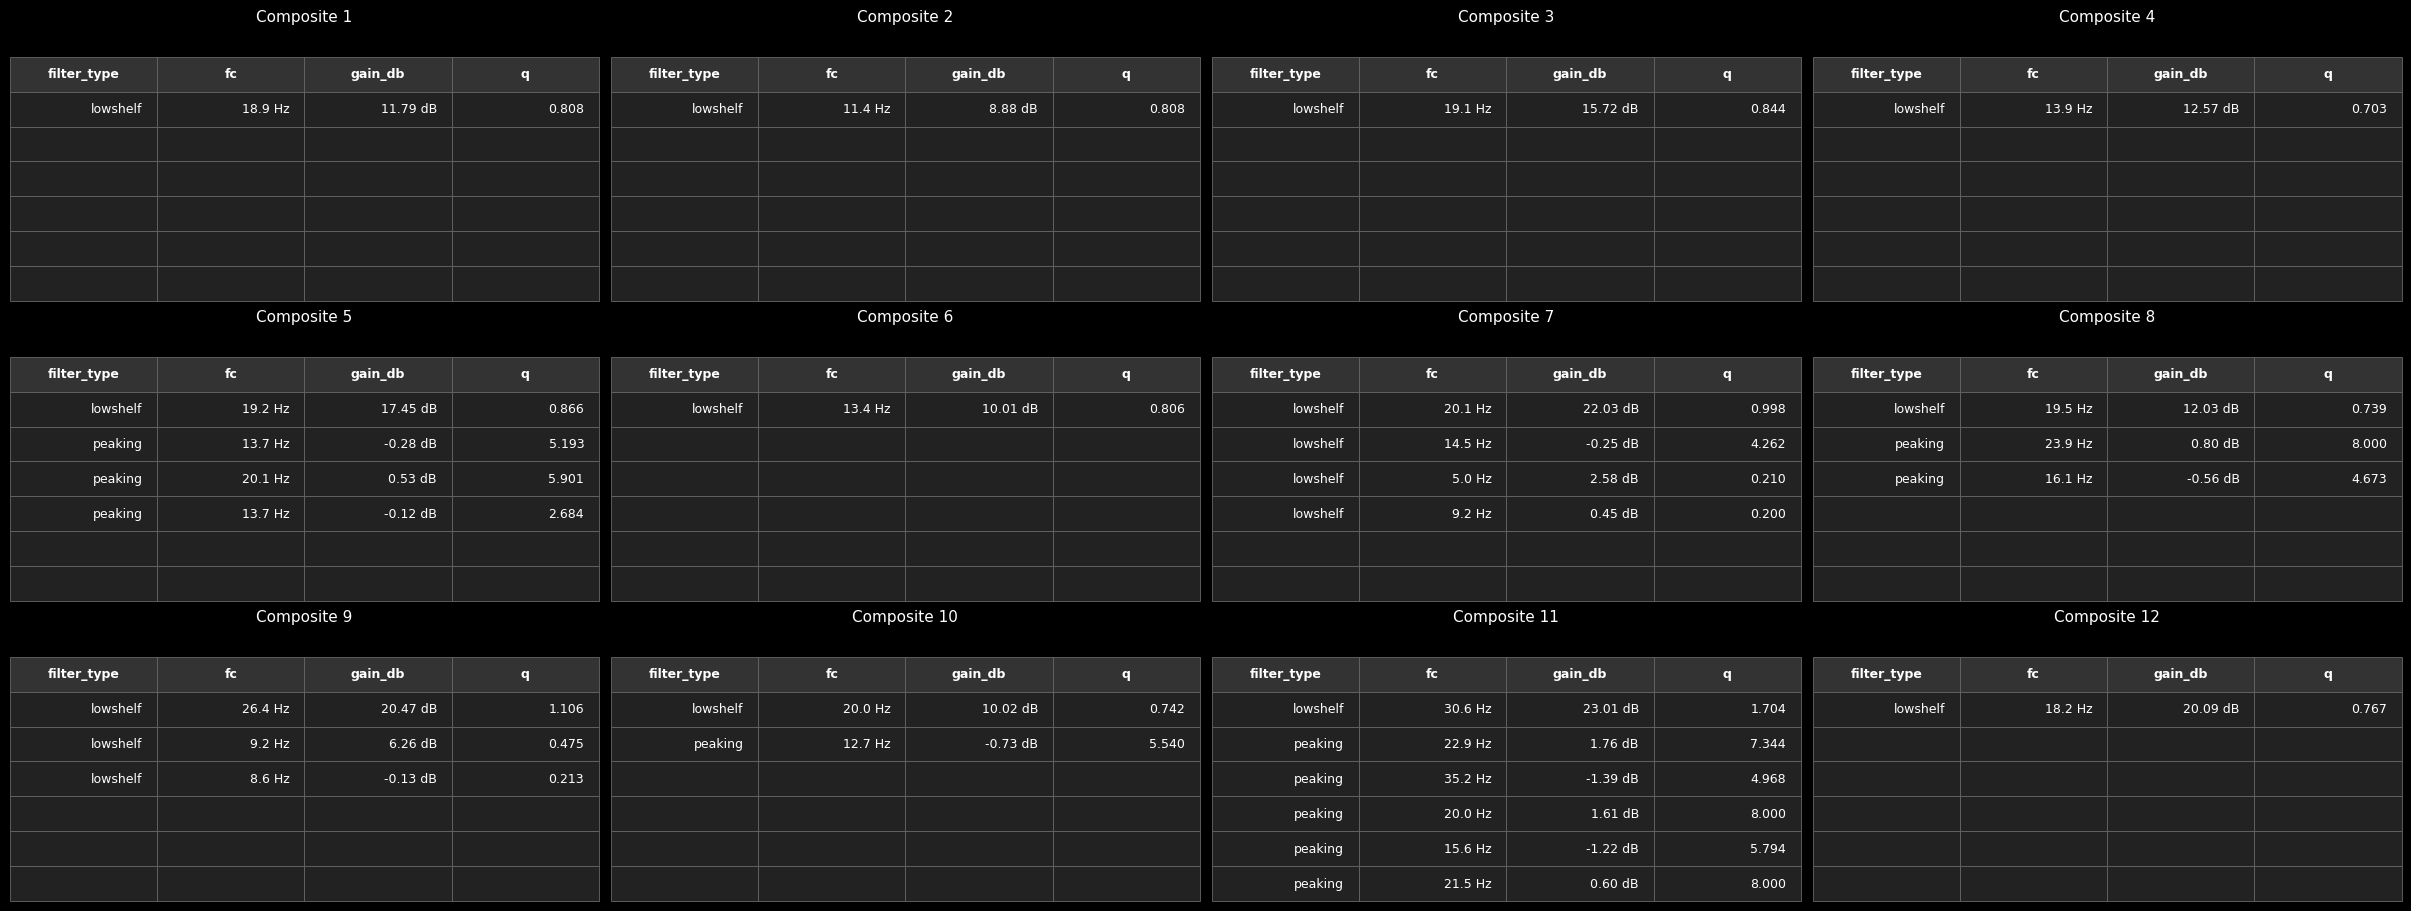

In [8]:
from beqanalyser.reporter import show_filters
show_filters({f'Composite {i+1}': v['filters'] for i, v in peq_fit.items()})

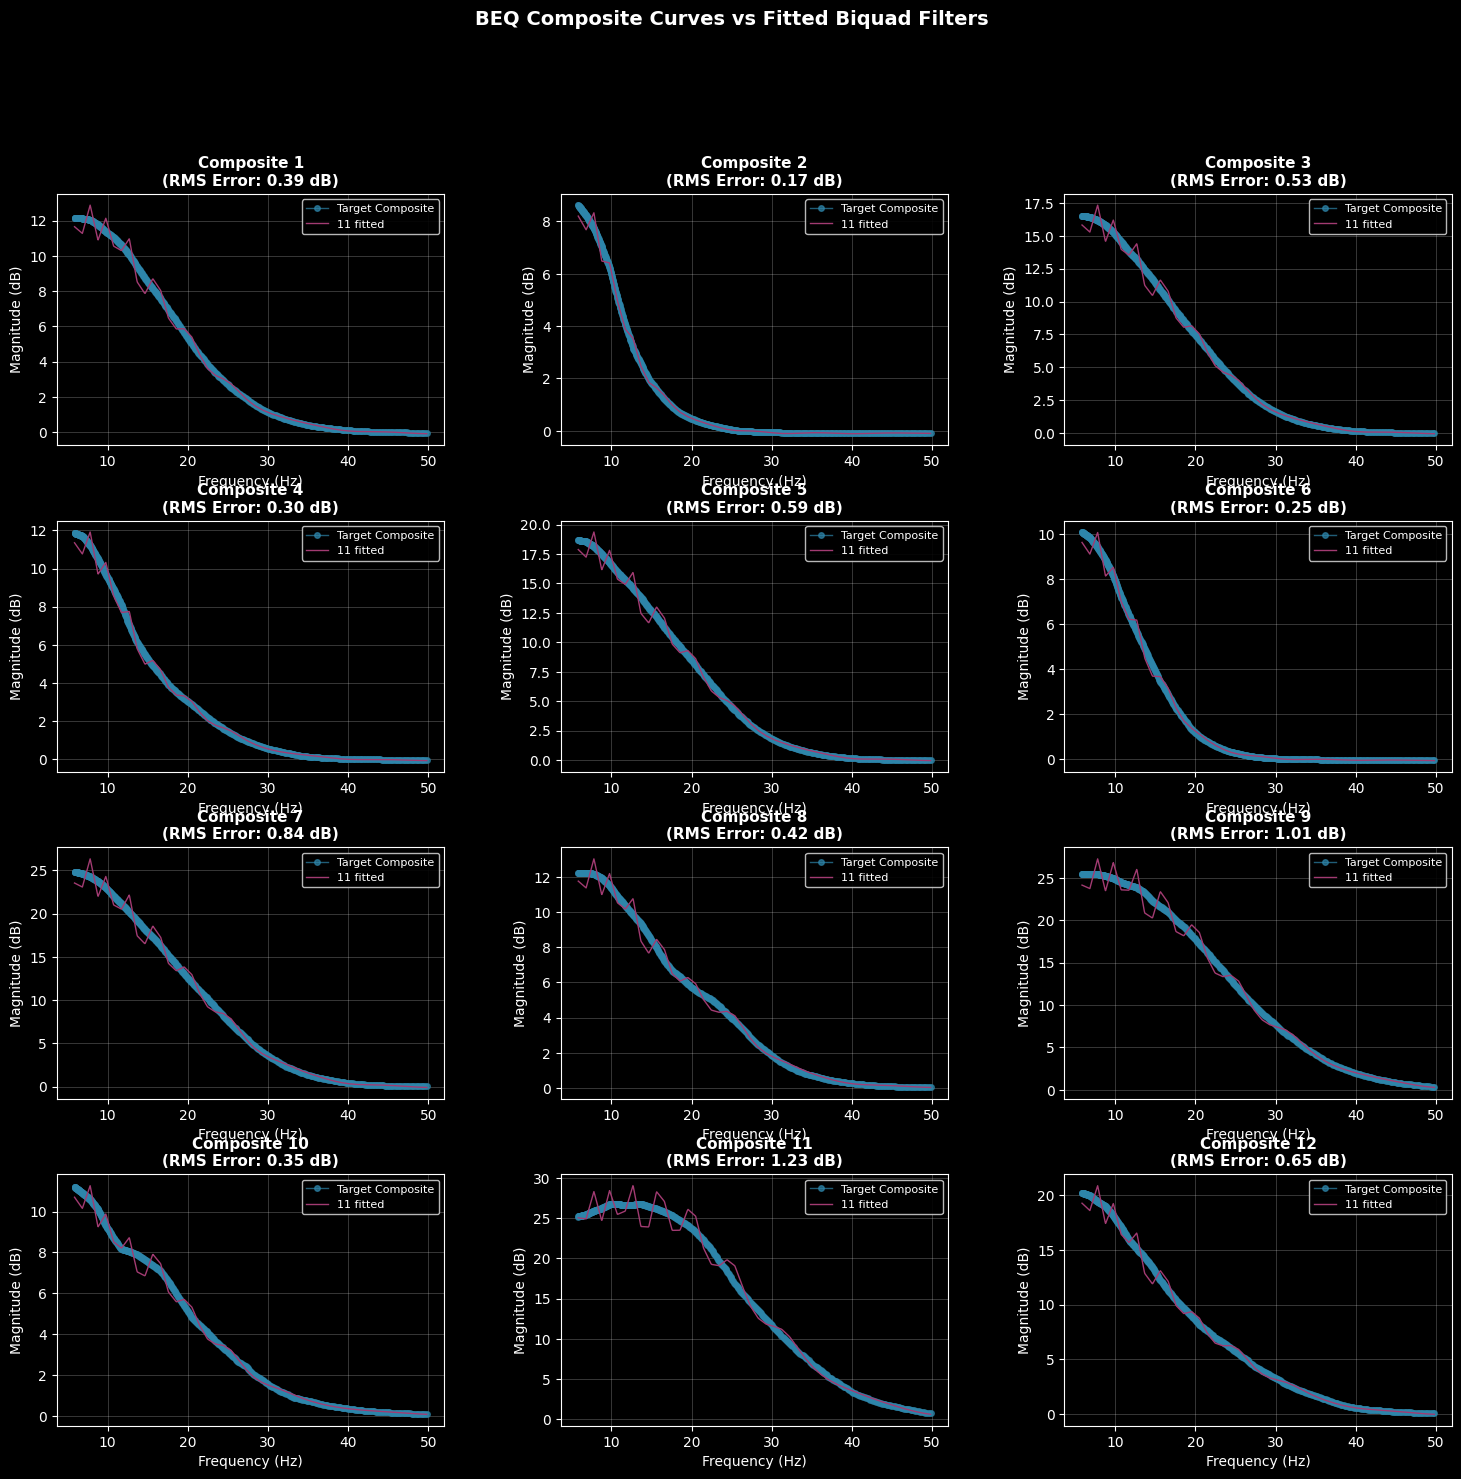

In [9]:
from beqanalyser.reporter import plot_filter_comparison
from beqanalyser.filter import fit_all_composites_to_geq

geq_fit = fit_all_composites_to_geq(result.composites, in_band_freqs)
plot_filter_comparison(geq_fit)

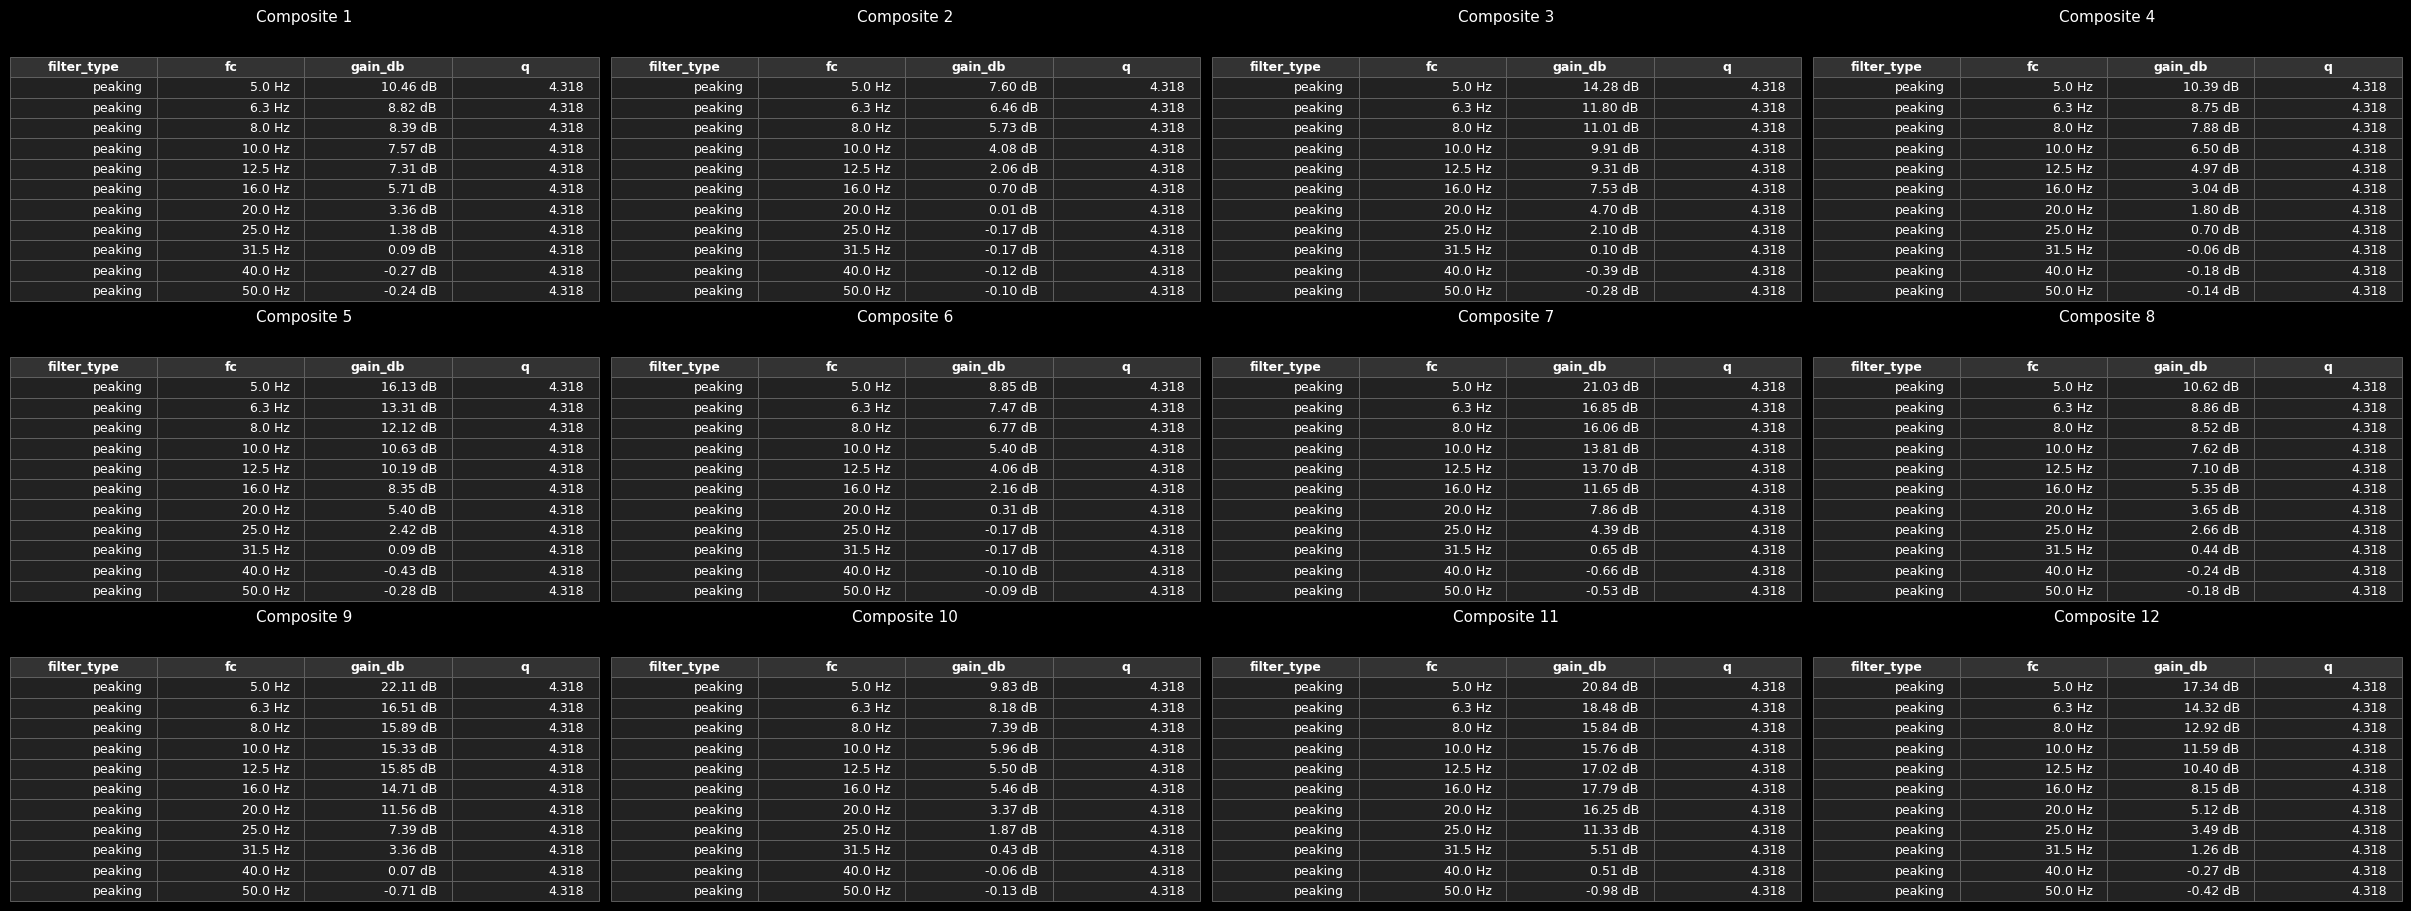

In [10]:
from beqanalyser.reporter import show_filters
show_filters({f'Composite {i+1}': v['filters'] for i, v in geq_fit.items()})

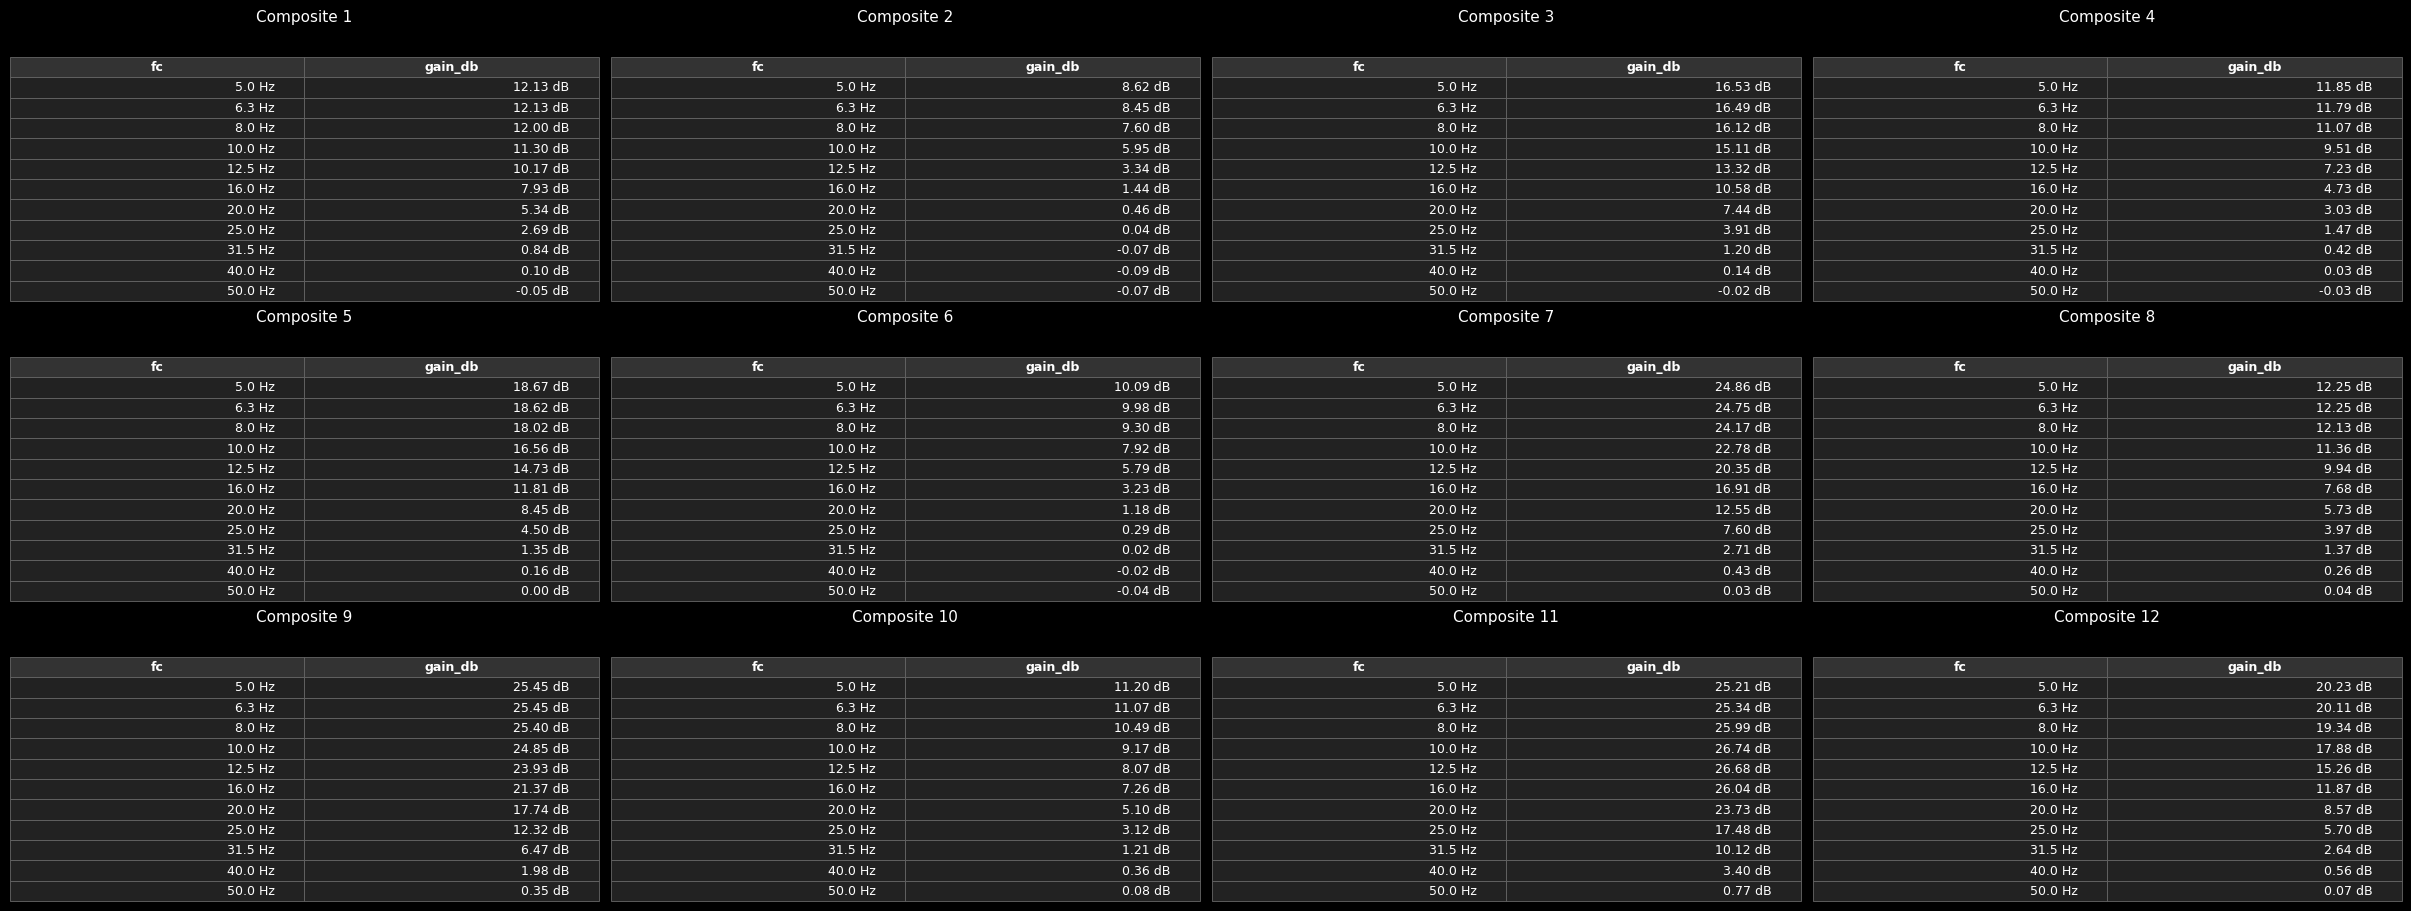

In [17]:
from beqanalyser.filter import fit_all_composites_to_mag
from beqanalyser.reporter import show_filters

mag_fit = fit_all_composites_to_mag(result.composites, in_band_freqs)
show_filters({f'Composite {i+1}': v['filters'] for i, v in mag_fit.items()})


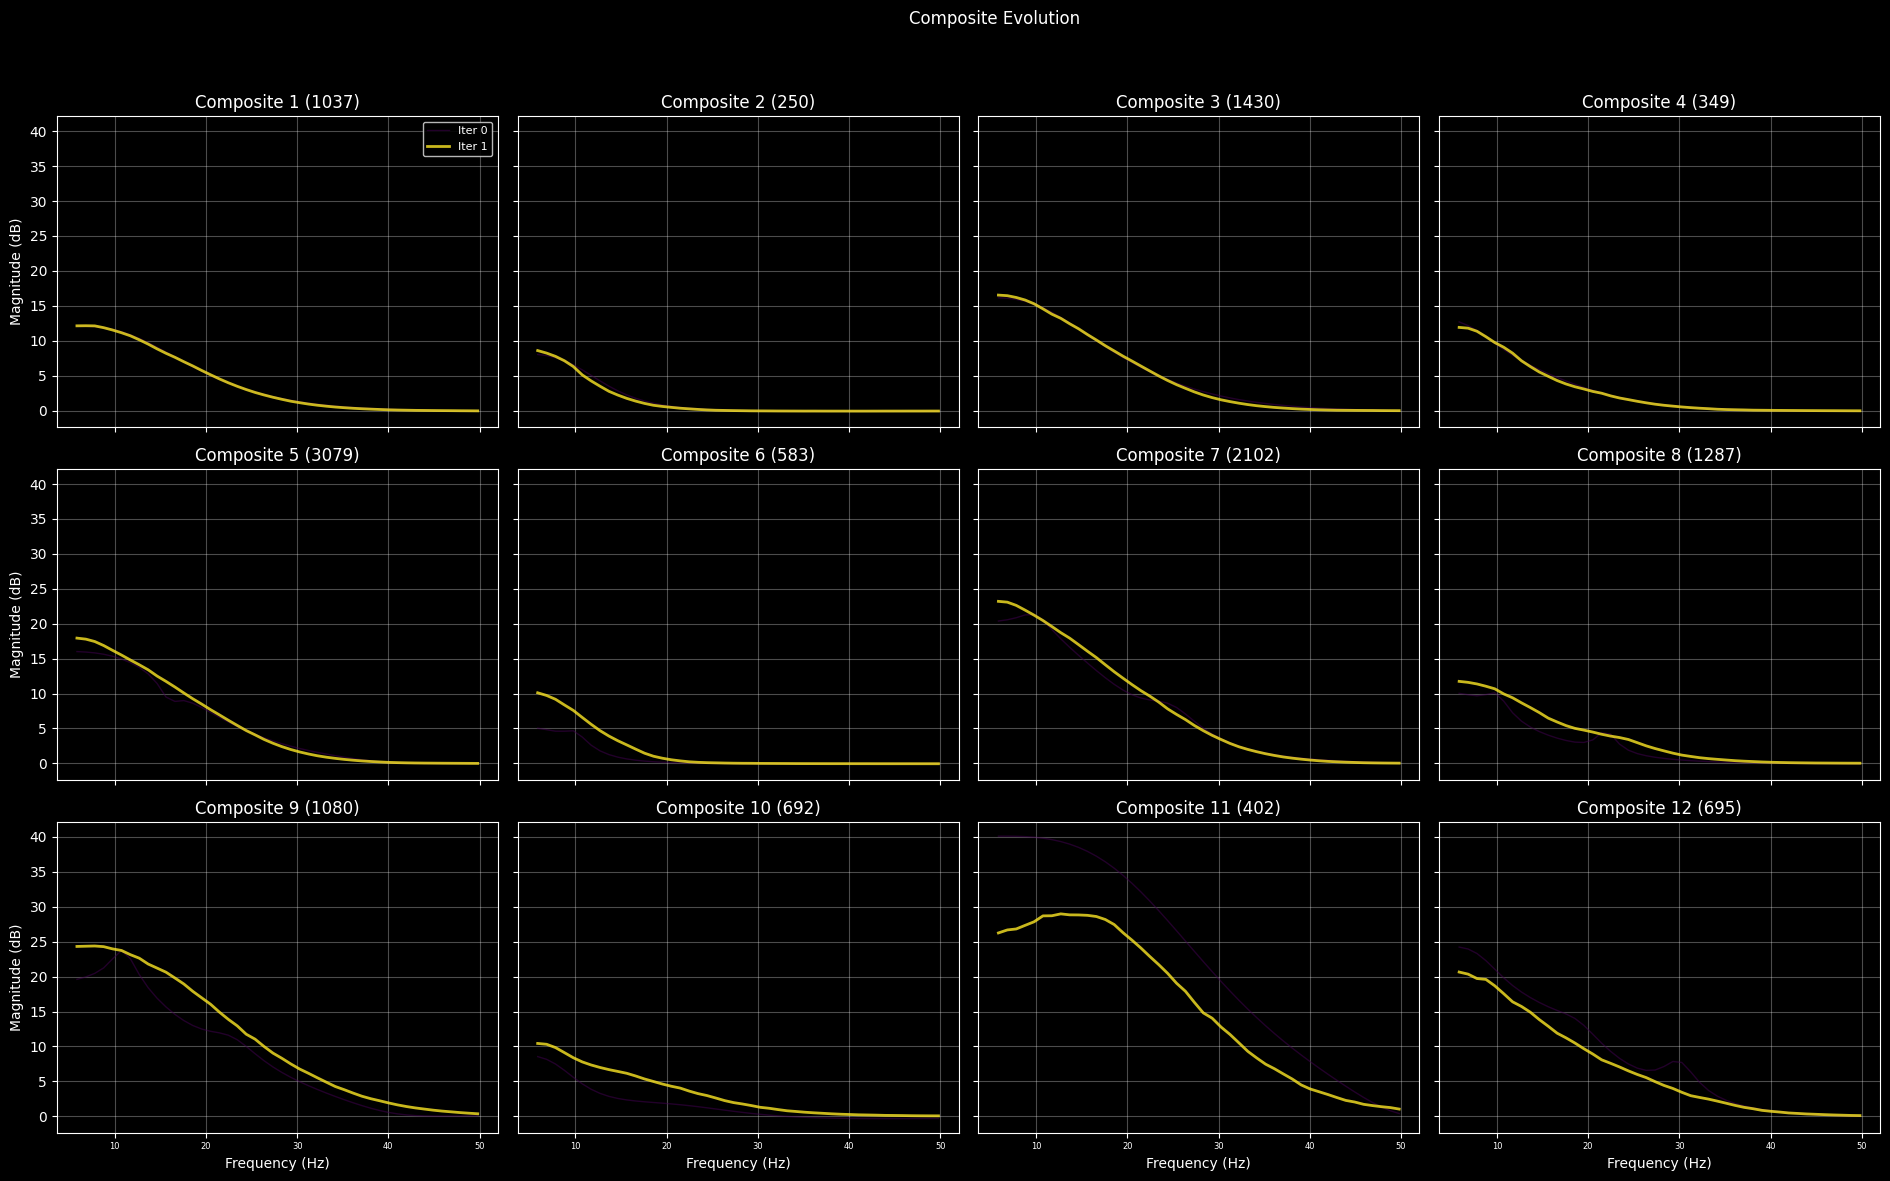

In [12]:
from beqanalyser.reporter import plot_composite_evolution

plot_composite_evolution(result, freqs, band=(min_freq, max_freq))

In [13]:
import logging
from beqanalyser.reporter import summarise_result, print_assignments, summarise_assignments

print_assignments(result.composites, catalogue)
summarise_result(result)
for i, c in enumerate(result.calculations, start=1):
    summarise_assignments(i, c, level=logging.INFO)